# Regression
## Objectives
- Fit and evaluate a regression model to predict the sale price

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/Retail-Sales-Prediction/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/Retail-Sales-Prediction'

### Import required libraries

In [4]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from feature_engine.selection import SmartCorrelatedSelection
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

### Load Data

In [5]:
train_data = pd.read_csv('outputs/TrainData.csv')
validation_data = pd.read_csv('outputs/ValidationData.csv')
test_data = pd.read_csv('outputs/TestData.csv')

#Drop the "Date" column from the training, validation, and test datasets
train_data = train_data.drop(columns=['Date'])
validation_data = validation_data.drop(columns=['Date'])
test_data = test_data.drop(columns=['Date'])

### Split the data into features and target

In [6]:
X_train = train_data.drop(columns='Weekly_Sales')
y_train = train_data['Weekly_Sales']

X_valid = validation_data.drop(columns='Weekly_Sales')
y_valid = validation_data['Weekly_Sales']

X_test = test_data.drop(columns='Weekly_Sales')
y_test = test_data['Weekly_Sales']

### Create ML Pipeline

In [7]:
def create_pipeline(model):
    pipeline = Pipeline([
        ("smart_correlated_selection", SmartCorrelatedSelection(threshold=0.8)),
        ("feat_scaling", StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model)
    ])
    return pipeline

### Custom Class for Hyperparameter Optimization

In [8]:
class HyperparameterOptimizationSearch:
    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = create_pipeline(self.models[key])
            gs = GridSearchCV(model, self.params[key], cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        return df, self.grid_searches

### Grid Search CV - Sklearn (Initial Search)

In [9]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    'DecisionTreeRegressor': DecisionTreeRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    'DecisionTreeRegressor': {},
    'GradientBoostingRegressor':{},
}

Do a hyperparameter optimization search using default hyperparameters

In [10]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_valid, y_valid, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.9/site-packages/feature_engine/selection/smart_correlation_selection.py:259: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].isnull().sum().sort_values(ascending=True).index[0]
/workspace/.pip-modules/lib/python3.9/site-packages/feature_engine/selection/smart_correlation_selection.py:259: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].isnull().sum().sort_values(ascending=True).index[0]
/workspace/.pip-modules/lib/python3.9/site-packages/feature_engine/selection/smart_correlation_selection.py:259: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].isnull().sum().sort_values(ascending=True).index[0]
/workspace/.pip-modules/lib/python3.9/site-packages/feature_engine/selection/smart_correlation_se


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.9/site-packages/feature_engine/selection/smart_correlation_selection.py:259: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].isnull().sum().sort_values(ascending=True).index[0]
/workspace/.pip-modules/lib/python3.9/site-packages/feature_engine/selection/smart_correlation_selection.py:259: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].isnull().sum().sort_values(ascending=True).index[0]
/workspace/.pip-modules/lib/python3.9/site-packages/feature_engine/selection/smart_correlation_selection.py:259: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].isnull().sum().sort_values(ascending=True).index[0]
/workspace/.pip-modules/lib/python3.9/site-packages/feature_engine/selection/smart_correlation_se


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.9/site-packages/feature_engine/selection/smart_correlation_selection.py:259: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].isnull().sum().sort_values(ascending=True).index[0]
/workspace/.pip-modules/lib/python3.9/site-packages/feature_engine/selection/smart_correlation_selection.py:259: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].isnull().sum().sort_values(ascending=True).index[0]
/workspace/.pip-modules/lib/python3.9/site-packages/feature_engine/selection/smart_correlation_selection.py:259: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].isnull().sum().sort_values(ascending=True).index[0]
/workspace/.pip-modules/lib/python3.9/site-packages/feature_engine/selection/smart_correlation_se

Check results

In [11]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary.head()

,estimator,min_score,max_score,mean_score,std_score
2,GradientBoostingRegressor,0.53368,0.768407,0.694721,0.087946
1,DecisionTreeRegressor,-1.010386,0.877733,0.427648,0.723304
0,LinearRegression,-0.555374,0.01625,-0.108319,0.223627


Best Model

In [12]:
best_model = grid_search_summary.iloc[0]['estimator']
best_model

'GradientBoostingRegressor'

Best Parameters for the best model

In [13]:
grid_search_pipelines[best_model].best_params_

{}

Define the best regressor, based on the search

In [14]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('smart_correlated_selection',
                 SmartCorrelatedSelection(variables=['Temperature',
                                                     'Fuel_Price', 'MarkDown1',
                                                     'MarkDown2', 'MarkDown3',
                                                     'MarkDown4', 'MarkDown5',
                                                     'CPI', 'Unemployment',
                                                     'Size', 'Store_1',
                                                     'Store_2', 'Store_3',
                                                     'Store_4', 'Store_5',
                                                     'Store_6', 'Store_7',
                                                     'Store_8', 'Store_9',
                                                     'Store_10', 'Store_11',
                                                     'Store_12', 'Store_13',
                                             

### Assess Feature Importance

In [15]:
data_cleaning_feat_eng_steps = 1
columns_after_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                          .transform(X_train).columns)

best_features = columns_after_feat_eng[best_regressor_pipeline['feat_selection'].get_support()].tolist()

Plot feature importance

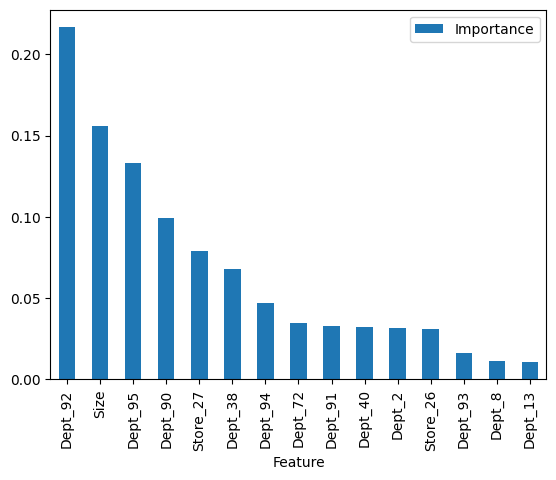

In [16]:
df_feature_importance = pd.DataFrame({
    'Feature': best_features,
    'Importance': best_regressor_pipeline['model'].feature_importances_
}).sort_values(by='Importance', ascending=False)

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

### Pipeline for MultiLayerPerceptron (can't include feat_selection step)

In [17]:
def create_pipeline_MLP(model):
    pipeline = Pipeline([
        ("smart_correlated_selection", SmartCorrelatedSelection(threshold=0.8)),
        ("feat_scaling", StandardScaler()),
        ("model", model)
    ])
    return pipeline

class HyperparameterOptimizationSearchMLP:
    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = create_pipeline_MLP(self.models[key])
            gs = GridSearchCV(model, self.params[key], cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        return df, self.grid_searches

In [18]:
models_quick_search_MLP = {
    'LinearRegression': LinearRegression(),
    'DecisionTreeRegressor': DecisionTreeRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    'MLPRegressor': MLPRegressor(random_state=0),
}

params_quick_search_MLP = {
    'LinearRegression': {},
    'DecisionTreeRegressor': {},
    'GradientBoostingRegressor':{},
    'MLPRegressor': {
        'model__hidden_layer_sizes': [(4, 2), (6, 3), (8, 4)],  # k = 2, 3, 4
        'model__alpha': [0.0001, 0.001, 0.01],
        'model__learning_rate_init': [0.001, 0.01, 0.1]
    }
}

In [19]:
search_MLP = HyperparameterOptimizationSearchMLP(models=models_quick_search_MLP, params=params_quick_search_MLP)
search_MLP.fit(X_valid, y_valid, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.9/site-packages/feature_engine/selection/smart_correlation_selection.py:259: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].isnull().sum().sort_values(ascending=True).index[0]
/workspace/.pip-modules/lib/python3.9/site-packages/feature_engine/selection/smart_correlation_selection.py:259: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].isnull().sum().sort_values(ascending=True).index[0]
/workspace/.pip-modules/lib/python3.9/site-packages/feature_engine/selection/smart_correlation_selection.py:259: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].isnull().sum().sort_values(ascending=True).index[0]
/workspace/.pip-modules/lib/python3.9/site-packages/feature_engine/selection/smart_correlation_se


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.9/site-packages/feature_engine/selection/smart_correlation_selection.py:259: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].isnull().sum().sort_values(ascending=True).index[0]
/workspace/.pip-modules/lib/python3.9/site-packages/feature_engine/selection/smart_correlation_selection.py:259: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].isnull().sum().sort_values(ascending=True).index[0]
/workspace/.pip-modules/lib/python3.9/site-packages/feature_engine/selection/smart_correlation_selection.py:259: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].isnull().sum().sort_values(ascending=True).index[0]
/workspace/.pip-modules/lib/python3.9/site-packages/feature_engine/selection/smart_correlation_se


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.9/site-packages/feature_engine/selection/smart_correlation_selection.py:259: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].isnull().sum().sort_values(ascending=True).index[0]
/workspace/.pip-modules/lib/python3.9/site-packages/feature_engine/selection/smart_correlation_selection.py:259: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].isnull().sum().sort_values(ascending=True).index[0]
/workspace/.pip-modules/lib/python3.9/site-packages/feature_engine/selection/smart_correlation_selection.py:259: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].isnull().sum().sort_values(ascending=True).index[0]
/workspace/.pip-modules/lib/python3.9/site-packages/feature_engine/selection/smart_correlation_se


Running GridSearchCV for MLPRegressor 

Fitting 5 folds for each of 27 candidates, totalling 135 fits


/workspace/.pip-modules/lib/python3.9/site-packages/feature_engine/selection/smart_correlation_selection.py:259: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].isnull().sum().sort_values(ascending=True).index[0]
/workspace/.pip-modules/lib/python3.9/site-packages/feature_engine/selection/smart_correlation_selection.py:259: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].isnull().sum().sort_values(ascending=True).index[0]
/workspace/.pip-modules/lib/python3.9/site-packages/feature_engine/selection/smart_correlation_selection.py:259: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].isnull().sum().sort_values(ascending=True).index[0]
/workspace/.pip-modules/lib/python3.9/site-packages/feature_engine/selection/smart_correlation_se

In [20]:
grid_search_summary_MLP, grid_search_pipelines_MLP = search_MLP.score_summary(sort_by='mean_score')
grid_search_summary_MLP.head()

,estimator,min_score,max_score,mean_score,std_score,model__alpha,model__hidden_layer_sizes,model__learning_rate_init
29,MLPRegressor,0.68787,0.941354,0.84964,0.098385,0.01,"(8, 4)",0.1
25,MLPRegressor,0.70995,0.920124,0.846281,0.081142,0.01,"(6, 3)",0.01
26,MLPRegressor,0.629869,0.935663,0.841697,0.112714,0.01,"(6, 3)",0.1
17,MLPRegressor,0.666294,0.933534,0.837862,0.093836,0.001,"(6, 3)",0.1
5,MLPRegressor,0.752501,0.912302,0.836002,0.055675,0.0001,"(4, 2)",0.1


In [21]:
best_model_MLP = grid_search_summary_MLP.iloc[0]['estimator']
best_model_MLP

'MLPRegressor'

In [22]:
best_regressor_pipeline_MLP = grid_search_pipelines_MLP[best_model_MLP].best_estimator_
best_regressor_pipeline_MLP

Pipeline(steps=[('smart_correlated_selection',
                 SmartCorrelatedSelection(variables=['Temperature',
                                                     'Fuel_Price', 'MarkDown1',
                                                     'MarkDown2', 'MarkDown3',
                                                     'MarkDown4', 'MarkDown5',
                                                     'CPI', 'Unemployment',
                                                     'Size', 'Store_1',
                                                     'Store_2', 'Store_3',
                                                     'Store_4', 'Store_5',
                                                     'Store_6', 'Store_7',
                                                     'Store_8', 'Store_9',
                                                     'Store_10', 'Store_11',
                                                     'Store_12', 'Store_13',
                                             

### Evaluate on Train and Test Sets

In [23]:
def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()

Evaluate Performance

Model Evaluation 

* Train Set
R2 Score: 0.442
Mean Absolute Error: 10095.222
Mean Squared Error: 311248570.965
Root Mean Squared Error: 17642.238


* Test Set
R2 Score: 0.572
Mean Absolute Error: 7803.302
Mean Squared Error: 172245549.156
Root Mean Squared Error: 13124.235




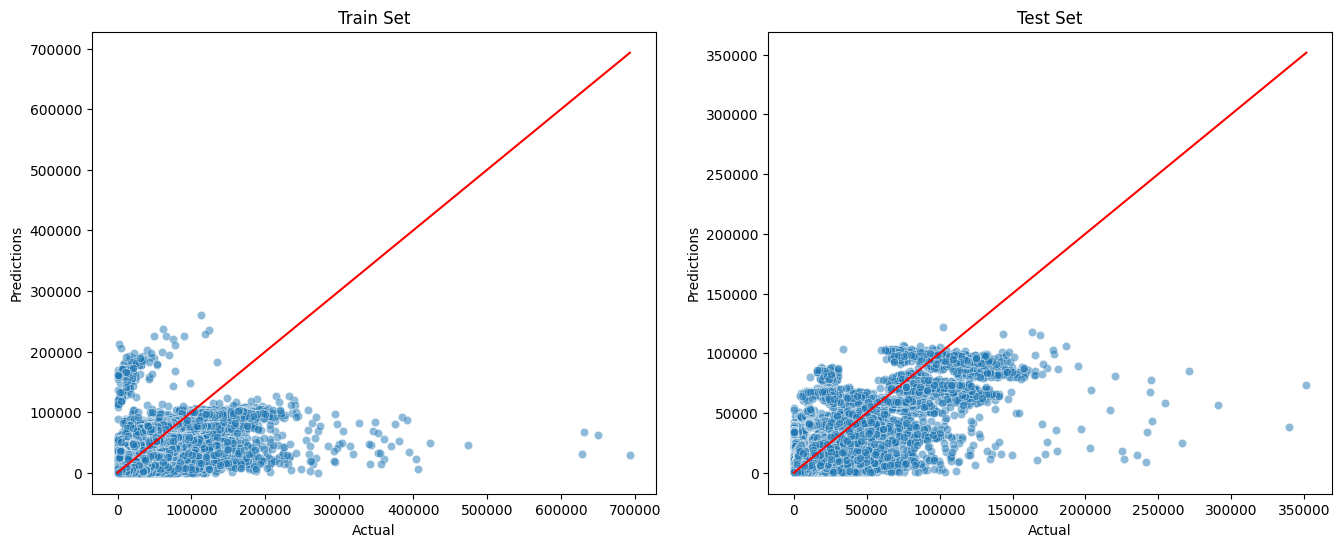

In [24]:
regression_performance(X_train, y_train, X_test, y_test,best_regressor_pipeline_MLP)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline_MLP)

### Forecast

As an example we will produce forecast for hte first 3 rows of Test set

In [25]:
predictions = best_regressor_pipeline_MLP.predict(X_test.iloc[0:3,:])

print(predictions)

[10110.57901559 23547.06163605   255.72427159]


### Push files to the repo

In [26]:
version = 'v1'
file_path = f'outputs/ml_pipeline/predict_sales/{version}'

os.makedirs(file_path, exist_ok=True)

Save train, validation, and test sets with best features

In [27]:
X_train_filtered = X_train.filter(best_features)
X_test_filtered = X_test.filter(best_features)

X_train_filtered.to_csv(f"{file_path}/X_train.csv", index=False)
y_train.to_csv(f"{file_path}/y_train.csv", index=False)
X_test_filtered.to_csv(f"{file_path}/X_test.csv", index=False)
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

Save model pipeline

In [28]:
joblib.dump(best_regressor_pipeline_MLP, f"{file_path}/pipeline_reg.pkl")

['outputs/ml_pipeline/predict_sales/v1/pipeline_reg.pkl']

Save feature importance plot

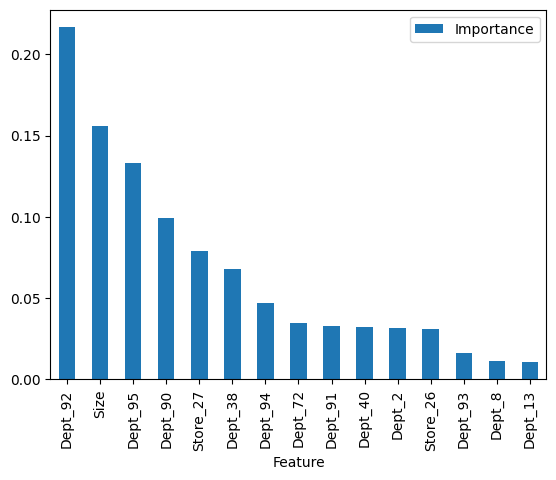

In [29]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.savefig(f"{file_path}/features_importance.png", bbox_inches='tight')